In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

#Plots
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [2]:
def diversity_attr_entropy(df, attribute):
    p = np.array(df[attribute].value_counts(normalize=True))
    return (- (p*np.log2(p)).sum())
def diversity_df(df):
    return np.mean([diversity_attr_entropy(df,attr) for attr in df.columns])

def diversity_attr_gini(df, attribute):
    p = np.array(df[attribute].value_counts(normalize=True))
    return 1 - (p ** 2).sum()
def diversity_df_gini(df):
    return np.mean([diversity_attr_gini(df, attr) for attr in df.columns])

In [3]:
def features_importance(X,y,threeshold=0.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Get feature importances from the trained model
    feature_importances = clf.feature_importances_

    # Sort indices in descending order of importance
    indices = np.argsort(feature_importances)[::-1]

    return [X_train.columns[indices[f]] for f in range(len(indices))  if feature_importances[indices[f]] >= threeshold ]


In [4]:
def edit_density_attr(X,y, attribute, percentage):
    vc = X[attribute].value_counts()
    indexes = X[ X[attribute] == vc.index[1]].sample(frac=percentage, random_state=42).index
    X_new = X.drop(indexes)
    y_new = y.drop(indexes)
    return X_new, y_new

def edit_density_df(X, y, percentage):
    features = X.columns #features_importance(X,y)
    X_new = X.copy()
    y_new = y.copy()
    for f in features:
        if X[f].nunique() <= 6 and X[f].nunique() >= 2 :
            X_new, y_new = edit_density_attr(X_new, y_new, f, percentage)
    return X_new.reset_index(drop=True), y_new.reset_index(drop=True)

In [5]:
measures_steps = {
    'Diversity_Gini': [0, 0.1, 0.2, 0.4, 0.5]
}
n_steps = len(list(measures_steps.values())[0])
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())
n_iteration = 5
metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps, n_iteration)),
    'Precision': np.zeros((len(classifiers), n_steps, n_iteration)),
    'Recall': np.zeros((len(classifiers), n_steps, n_iteration)),
    'F1 Score': np.zeros((len(classifiers), n_steps, n_iteration))
}

# Dataset

In [6]:
heart_attack = pd.read_csv('dataset/heart_attack.csv')
heart_attack = heart_attack.sample(frac=1, random_state=42).reset_index(drop=True)
X = heart_attack.drop('output', axis=1)
y = heart_attack['output']
dataset_name = 'heart_attack'

In [12]:
stroke = pd.read_csv('dataset/stroke.csv').sample(frac=1, random_state=42).reset_index(drop=True)
X = stroke.drop(['stroke', 'id'], axis=1)
y = stroke['stroke']
X.fillna(method='ffill', inplace=True)

enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i] = enc.fit_transform(X[i])

dataset_name = 'stroke'

In [15]:
marketing_campaign = pd.read_csv('dataset/marketing_campaign.csv', sep=';').sample(frac=1, random_state=42).reset_index(
    drop=True)
marketing_campaign = marketing_campaign.dropna()
marketing_campaign = marketing_campaign.reset_index(drop=True)
X = marketing_campaign.drop(['Response', 'ID', 'Dt_Customer'], axis=1)
y = marketing_campaign['Response']

enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i] = enc.fit_transform(X[i])

dataset_name = 'marketing_campaign'

In [18]:
heart_failure = pd.read_csv('dataset/heart_failure.csv')
X = heart_failure.drop(['HeartDisease'], axis=1)
y = heart_failure['HeartDisease']

enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i] = enc.fit_transform(X[i])

dataset_name = 'heart_failure'

In [21]:
airline_passenger = pd.read_csv('dataset/airline_passenger.csv')
airline_passenger.dropna(inplace=True)
airline_passenger = airline_passenger.reset_index(drop=True)

X = airline_passenger.drop(['satisfaction', 'Unnamed: 0', 'id'], axis=1)
y = airline_passenger['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})

enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i] = enc.fit_transform(X[i])

dataset_name = 'airline_passenger'

In [7]:
import time
duration_shannon = []


for k in range(0,1000):
    start_time = time.time()
    diversity_df(X)
    duration_shannon.append(time.time() - start_time)



In [8]:
duration_gini = []
for k in range(0,1000):
    start_time = time.time()
    diversity_df_gini(X)
    duration_gini.append(time.time() - start_time)

In [9]:
np.mean(duration_gini)

0.0023794400691986082

In [10]:
np.mean(duration_shannon)

0.0025501618385314942

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

measure_value = []
for k, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        X_train_new, y_train_new = edit_density_df(X_train, y_train, step)
        diversity=diversity_df_gini(X_train_new)
        measure_value.append(diversity)
        print(f'{step} {diversity}')

        for k in range(n_iteration):
            for j, (classifier_name, classifier) in enumerate(classifiers.items()):
                # Standardize the features (optional but often recommended)
                scaler = StandardScaler()
                train_X_scaled = scaler.fit_transform(X_train_new)
                test_X_scaled = scaler.transform(X_test)

                # Train the classifier
                classifier.fit(train_X_scaled, y_train_new)

                # Make predictions on the fixed test set
                predictions = classifier.predict(test_X_scaled)
                # Calculate metrics and store in the metrics dictionary
                metrics['Accuracy'][j, i, k] = accuracy_score(y_test, predictions)
                metrics['Precision'][j, i,k] = precision_score(y_test, predictions, average='weighted')
                metrics['Recall'][j, i,k] = recall_score(y_test, predictions, average='weighted')
                metrics['F1 Score'][j, i,k] = f1_score(y_test, predictions, average='weighted')

0 0.7312371771440925
0.1 0.7306891594621056
0.2 0.7254711748914354
0.4 0.7127177326676448
0.5 0.6962531866160404


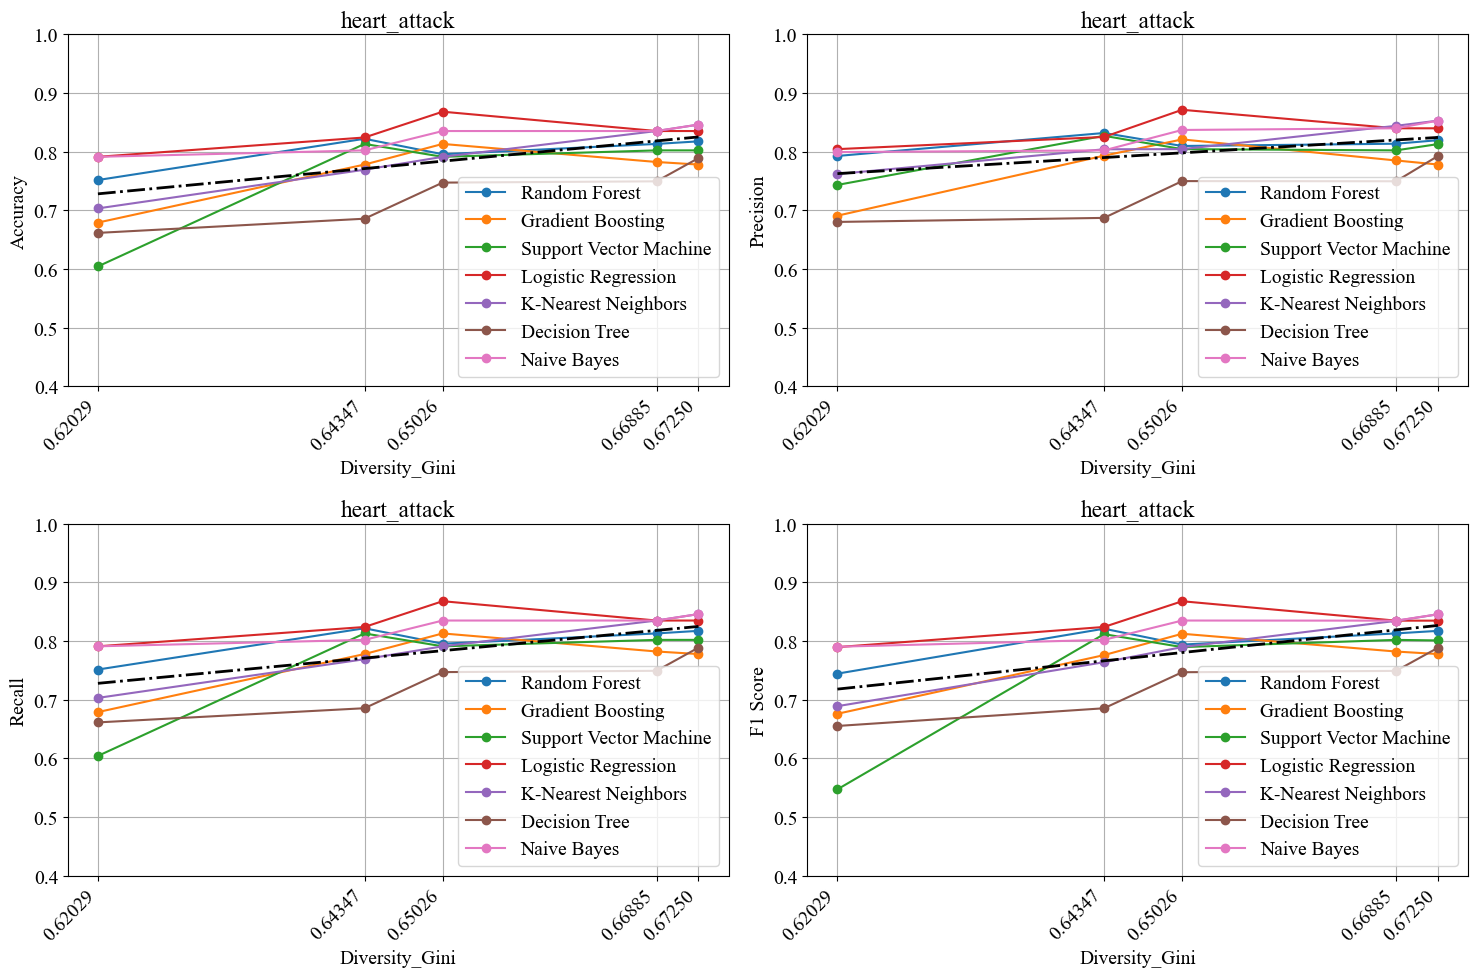

In [11]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, np.mean(metric[i, :],axis=1)))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(np.mean(metric,axis=2),axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)
    plt.grid(visible=True)

plt.tight_layout()
plt.savefig(f'plots/diversity_gini_{dataset_name}.svg', format='svg')
plt.show()

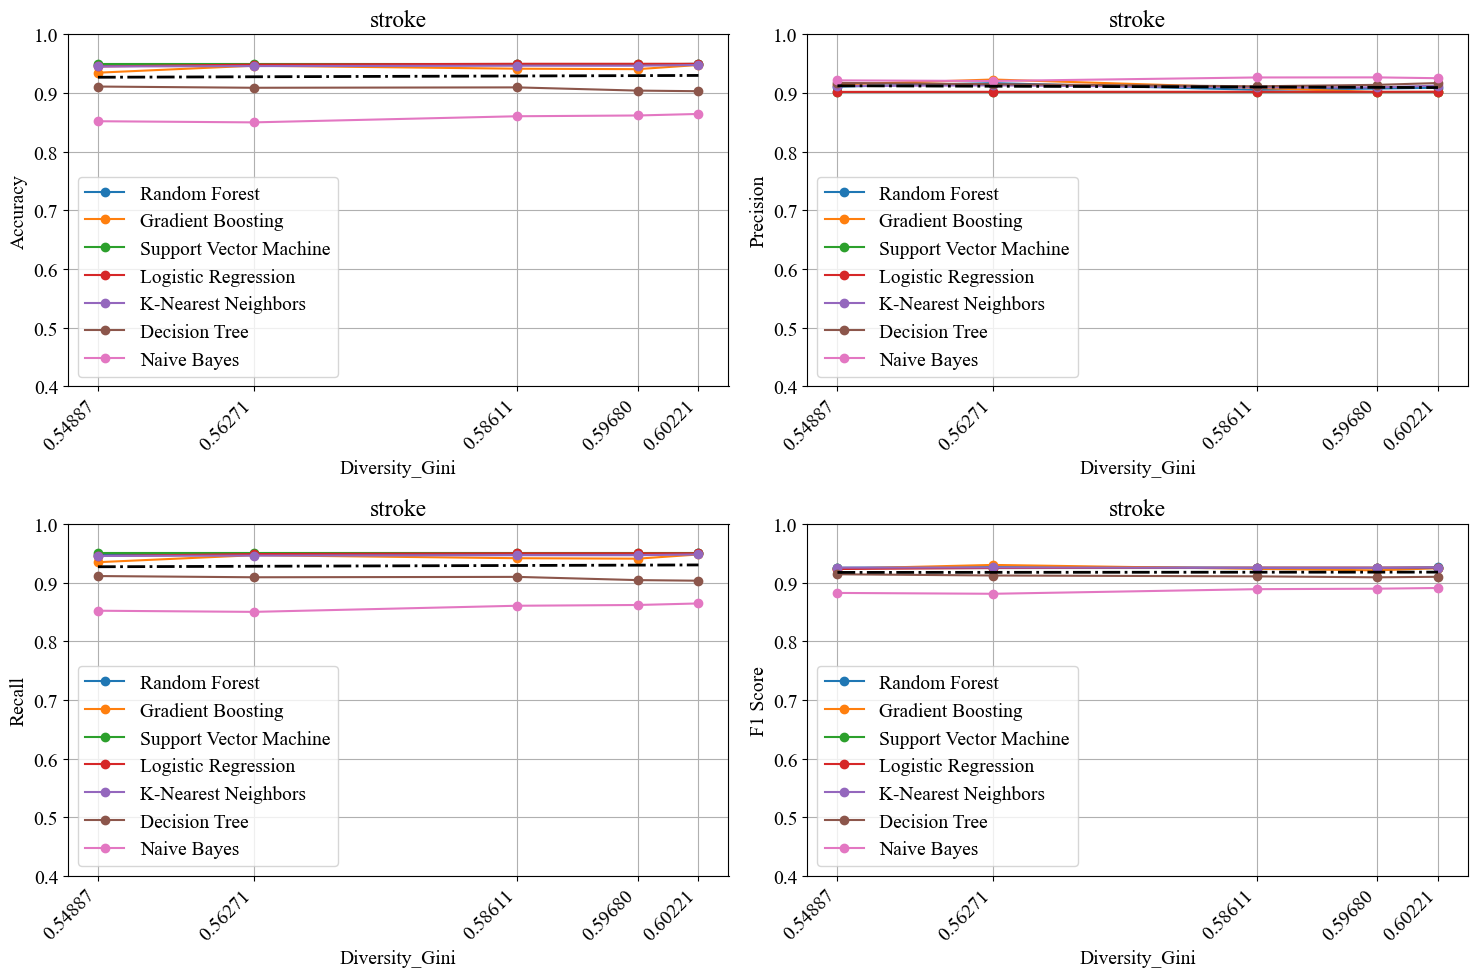

In [14]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, np.mean(metric[i, :],axis=1)))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(np.mean(metric,axis=2),axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)
    plt.grid(visible=True)

plt.tight_layout()
plt.savefig(f'plots/diversity_gini_{dataset_name}.svg', format='svg')
plt.show()


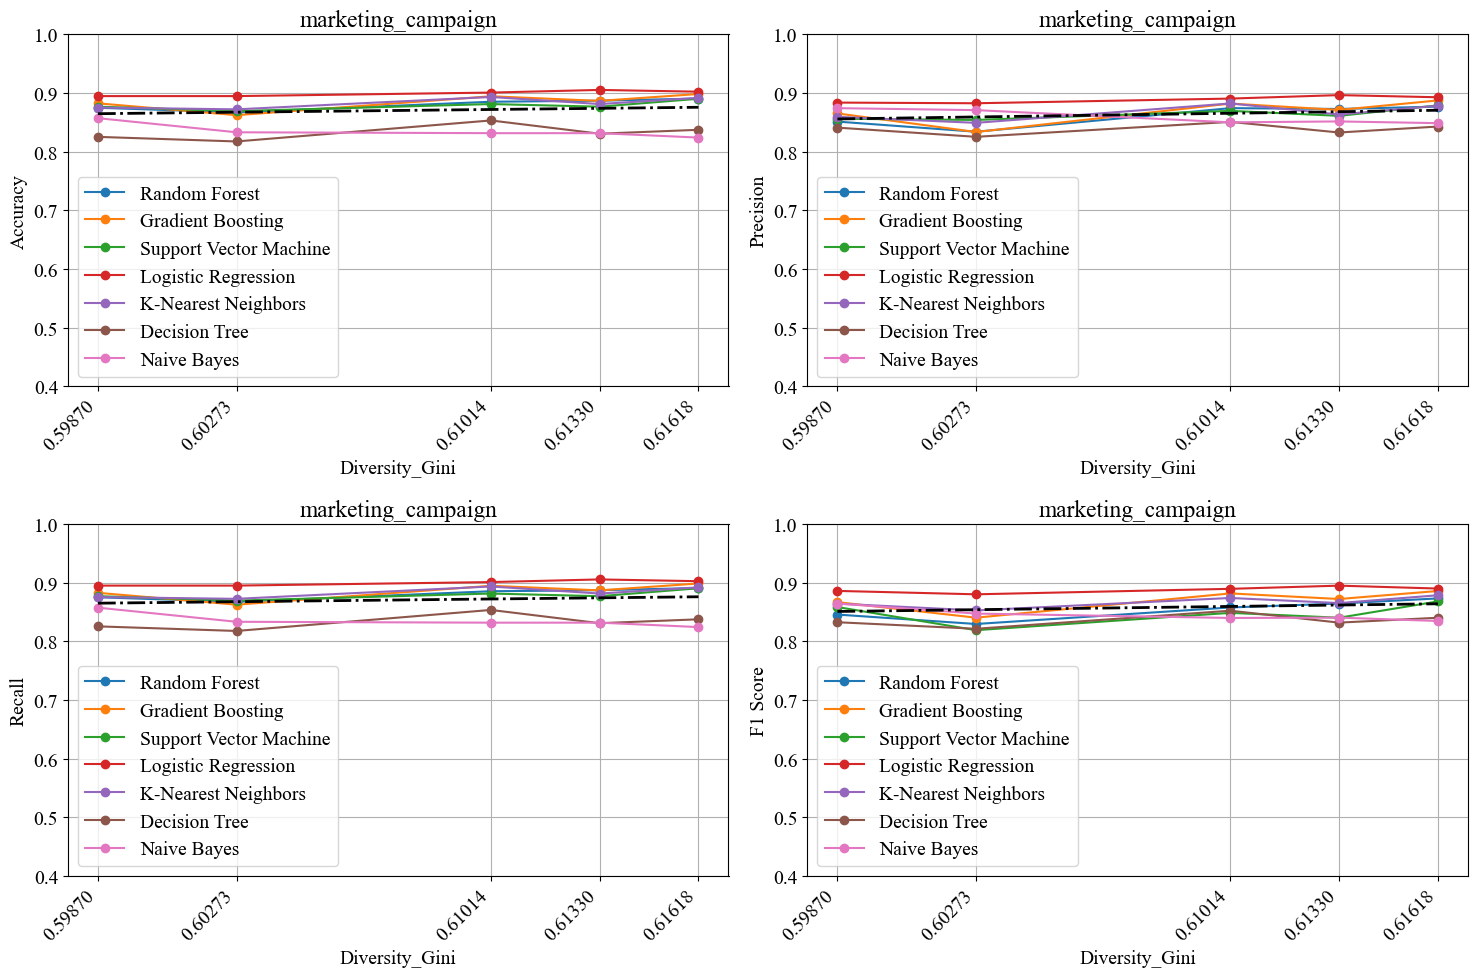

In [17]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, np.mean(metric[i, :],axis=1)))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(np.mean(metric,axis=2),axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)
    plt.grid(visible=True)

plt.tight_layout()
plt.savefig(f'plots/diversity_gini_{dataset_name}.svg', format='svg')
plt.show()


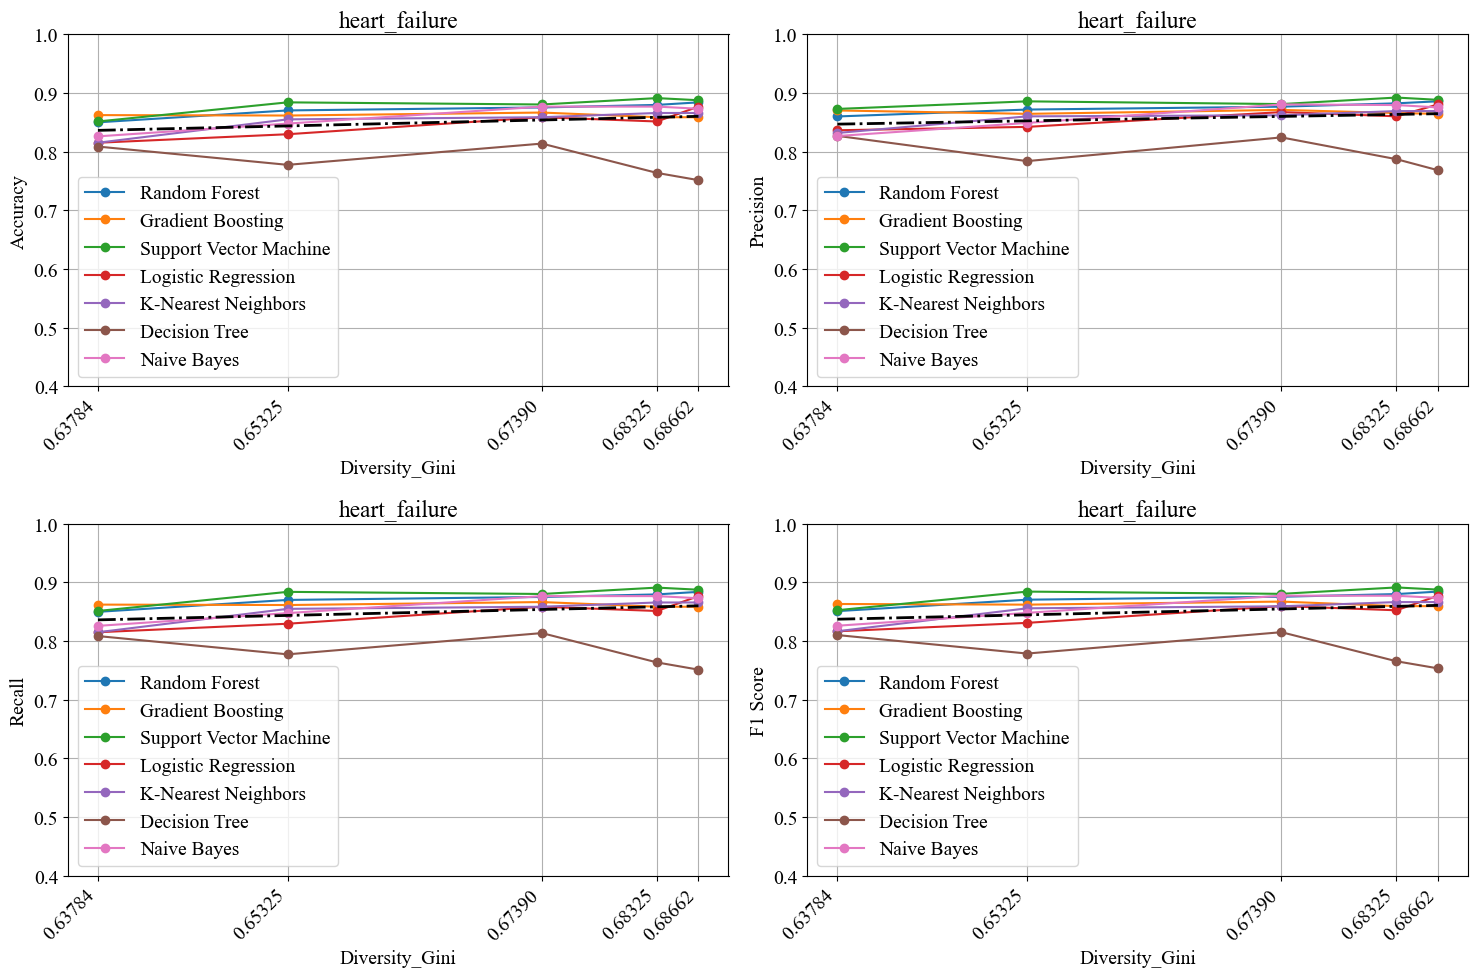

In [20]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, np.mean(metric[i, :],axis=1)))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(np.mean(metric,axis=2),axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)
    plt.grid(visible=True)

plt.tight_layout()
plt.savefig(f'plots/diversity_gini_{dataset_name}.svg', format='svg')
plt.show()


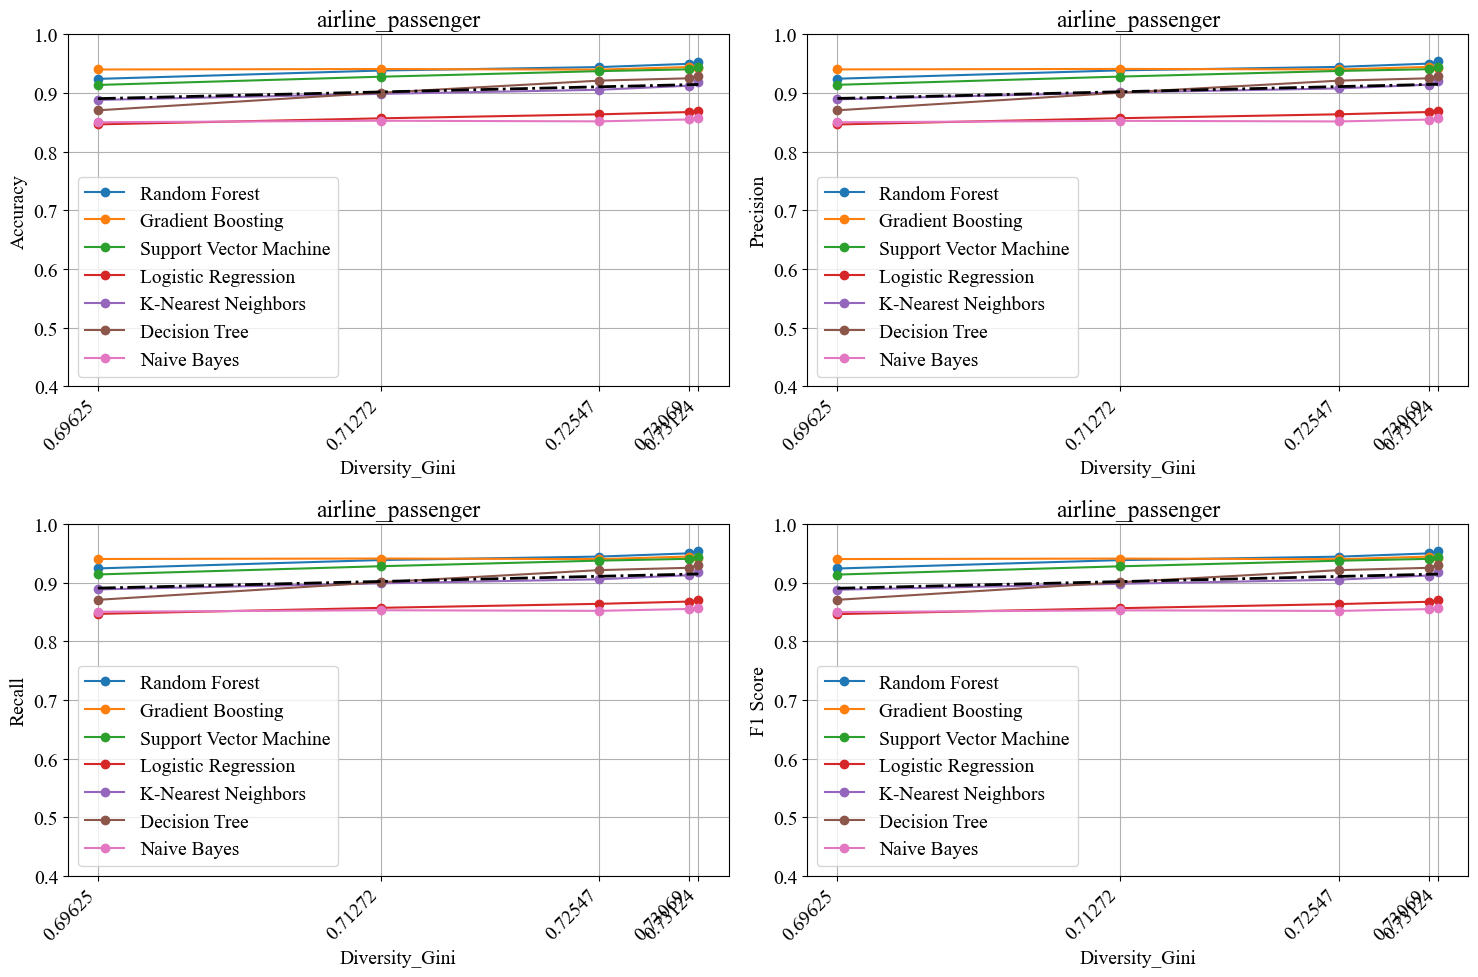

In [23]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, np.mean(metric[i, :],axis=1)))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(np.mean(metric,axis=2),axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)
    plt.grid(visible=True)

plt.tight_layout()
plt.savefig(f'plots/diversity_gini_{dataset_name}.svg', format='svg')
plt.show()
